# Prediction of energy generation from Solar Photovoltaic Power Plants using weather variables  

## Table of Contents <a class="anchor" id="0"></a>
* [Introduction](#1) 
* [Imports](#2)
* [Connecting to ArcGIS](#3)
* [Accessing & Visualizing the datasets](#4)    
    * [Training Set](#6)
    * [Validation Set](#7)        
* [Model Building](#9)
    * [1 — FullyConnectedNetwork](#10)
        * [Data Preprocessing](#11)  
        * [Model Initialization ](#12)
        * [Learning Rate Search ](#13)
        * [Model Training ](#14) 
        * [Solar Energy Generation Forecast & Validation](#15)  
        * [Result Visualization](#16)
    * [2 — MLModel](#17)
        * [Data Preprocessing](#18)  
        * [Model Initialization](#19)
        * [Model Training ](#20) 
        * [Solar Energy Generation Forecast & Validation](#21)  
        * [Result Visualization](#22)      
* [Conclusion](#23)
* [Summary of methods used](#24)
* [Data resources](#25)

## Introduction <a class="anchor" id="1"></a>

Recently there has been a great emphasis on reducing carbon footprint by moving away from fossil fuel to renewable energy sources for running our cities. Various local city governments across the world like in this case the City of Calgary in Canada is leading this change by becoming energy independent by installing solar power plants either on rooftops or within the site area of their city utilities for running its operation.

In view of the scenario here is a notebook that would predict the daily hence annual solar energy generation by a solar power station at a site using local weather information and site characteristics. The hypothesis is that various weather parameters such as temperature, wind speed, vapor pressure, solar radiation, day length, precipitation, snowfall along with altitude of a place would impact the daily generation of solar energy.

Accordingly, these variables are used to train a model on actual solar power generated by solar stations located in Calgary, which could then be used to predict solar generation for probable solar plants at other locations. Besides the total energy generation would also depend on the capacity of the solar station established. For example, a 100kwp solar plant will generate more energy than a 50kwp plant, hence for the final output, the capacity of the plant is to be taken into consideration.

## Imports <a class="anchor" id="2"></a>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
from pandas import read_csv
from datetime import datetime
from IPython.display import Image, HTML

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler  
from sklearn.compose import make_column_transformer 
from sklearn.metrics import r2_score

import arcgis
from arcgis.gis import GIS
from arcgis.learn import FullyConnectedNetwork, MLModel, prepare_tabulardata

## Connecting to ArcGIS <a class="anchor" id="3"></a>

In [2]:
gis = GIS(profile="your_online_profile")

## Accessing & Visualizing datasets  <a class="anchor" id="4"></a>

The primary data used for this sample are as follows:

Out of the several solar photovoltaic power plants in the City of Calgary, 11 were selected for the study. The dataset contains two components:

1) Daily solar energy production for each power plant from September 2015 to December 2019. 

2) Corresponding daily weather measurements for the given sites. 

The datasets were obtained from multiple sources as mentioned here ([Data resources](#25)) and preprocessed to obtain the main dataset used here. Two feature layers was subsequently created out of them one for training and the other for validating. 

### Training Set <a class="anchor" id="6"></a>

It consists of data from 10 solar sites for training the model. The feature layer containing the data is accessed here from Arcgis portal and visualized as follows:

<Item title:"calgary_no_southland_solar" type:Feature Layer Collection owner:api_data_owner>
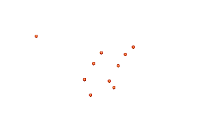

In [3]:
# Access Solar Dataset feature layer for Training, without the Southland Solar Plant which is hold out for validation
calgary_no_southland_solar = gis.content.search('calgary_no_southland_solar owner:api_data_owner', 'feature layer')[0]
calgary_no_southland_solar

In [4]:
# Access the layer from the feature layer
calgary_no_southland_solar_layer = calgary_no_southland_solar.layers[0]


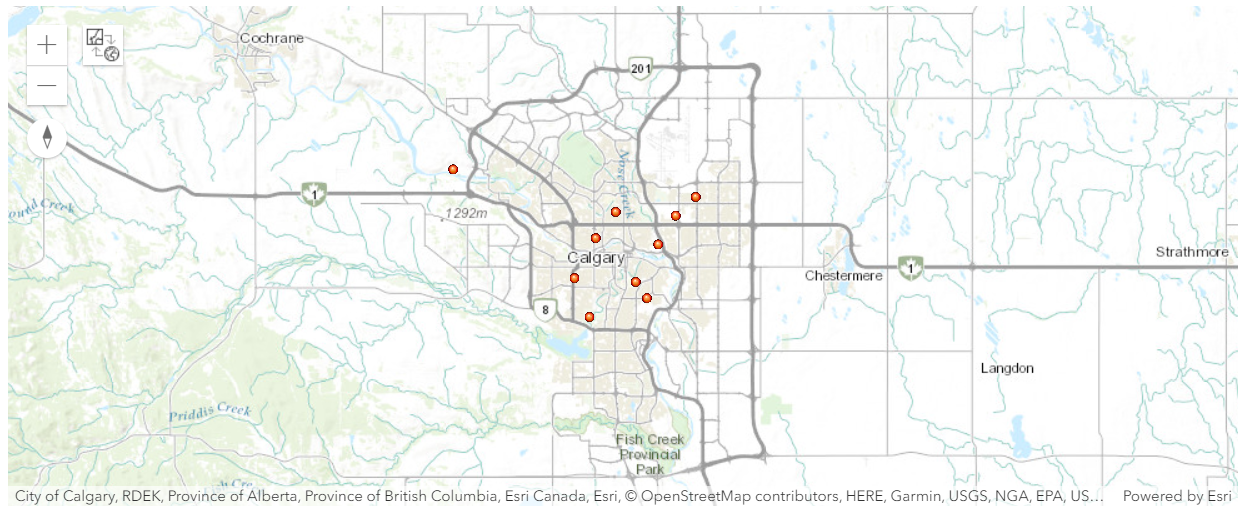

In [5]:
# Plot location of the 10 Solar sites in Calgary to be used for training
m1 = gis.map('calgary')
m1.content.add(calgary_no_southland_solar_layer)
m1

In [ ]:
m1.zoom = 10

The map above shows the 10 power plant locations that are used for collecting the training data.

In [6]:
# Visualize the dataframe
calgary_no_southland_solar_layer_sdf = calgary_no_southland_solar_layer.query().sdf
calgary_no_southland_solar_layer_sdf=calgary_no_southland_solar_layer_sdf[['FID','date','ID','solar_plan','altitude_m',
                                                                           'latitude','longitude','wind_speed','dayl__s_',
                                                                           'prcp__mm_d','srad__W_m_','swe__kg_m_', 'tmax__deg',
                                                                           'tmin__deg','vp__Pa_','kWh_filled','capacity_f',
                                                                           'SHAPE']]
calgary_no_southland_solar_layer_sdf.head()

FID       date      ID                      solar_plan  altitude_m  \
0    1 2017-12-24  355827  Glenmore Water Treatment Plant        1095   
1    2 2017-12-25  355827  Glenmore Water Treatment Plant        1095   
2    3 2017-12-26  355827  Glenmore Water Treatment Plant        1095   
3    4 2017-12-27  355827  Glenmore Water Treatment Plant        1095   
4    5 2017-12-28  355827  Glenmore Water Treatment Plant        1095   

    latitude   longitude  wind_speed  dayl__s_  prcp__mm_d  srad__W_m_  \
0  51.003078 -114.100571     7.20467   27648.0           1  108.800003   
1  51.003078 -114.100571    3.385235   27648.0           1  115.199997   
2  51.003078 -114.100571    5.076316   27648.0           0  118.400002   
3  51.003078 -114.100571    5.617623   27648.0           0        96.0   
4  51.003078 -114.100571    2.561512   27648.0           0  118.400002   

   swe__kg_m_  tmax__deg  tmin__deg  vp__Pa_  kWh_filled  capacity_f  \
0          12      -10.5      -21.0      120    1.242357    0.000177   
1          12      -18.0      -29.5       40    2.477714    0.000354   
2          12      -20.0      -32.0       40    3.713071     0.00053   
3          12      -18.0      -26.5       80    4.948429    0.000707   
4          12      -17.0      -28.5       40    6.183786    0.000883   

                                               SHAPE  
0  {"x": -12701617.407282012, "y": 6621838.159138...  
1  {"x": -12701617.407282012, "y": 6621838.159138...  
2  {"x": -12701617.407282012, "y": 6621838.159138...  
3  {"x": -12701617.407282012, "y": 6621838.159138...  
4  {"x": -12701617.407282012, "y": 6621838.159138...

In the above table, each row represents each day starting from September 2015 to December 2019, with the corresponding dates shown in the column named **date**, while the field **solar_plan** contains name of the solar sites.

The primary information consists of the daily generation of energy in kilowatt-hour(KWh) given here in the field name **kWh_filled** for each of the selected 10 solar photovoltaic power plants in the City of Calgary. The field **capacity_f** indicates the capacity factor which is obtained after normalizing the **kWh_filled** by the peak capacity of each solar photovoltaic sites, which will be used here as the dependent variable.   

In addition it contains data about weather variables for each day for the related solar plant, all of which except wind speed, was obtained from [MODIS, Daymet observations](https://daac.ornl.gov/DAYMET/guides/Daymet_V3_CFMosaics.html). These variables are as follows:

 - <span style='background :lightgrey' >wind_speed</span> : wind speed(m/sec)
 - <span style='background :lightgrey' >dayl__s_</span>   : Day length (sec/day)
 - <span style='background :lightgrey' >prcp__mm_d</span> : Precipitation (mm/day)
 - <span style='background :lightgrey' >srad__W_m_</span> : Shortwave radiation (W/m^2)
 - <span style='background :lightgrey' >swe__kg_m_</span> : Snow water equivalent (kg/m^2)	
 - <span style='background :lightgrey' >tmax__deg</span>  : Maximum air temperature (degrees C)
 - <span style='background :lightgrey' >tmin__deg</span>  : Minimum air temperature (degrees C)
 - <span style='background :lightgrey' >vp__Pa_</span>    : Water vapor pressure (Pa)

Now to understand the distribution of the variables over the last few years and their respective relationship with the dependent variable of daily energy produced for that stations, data from one of the station is plotted in the following.

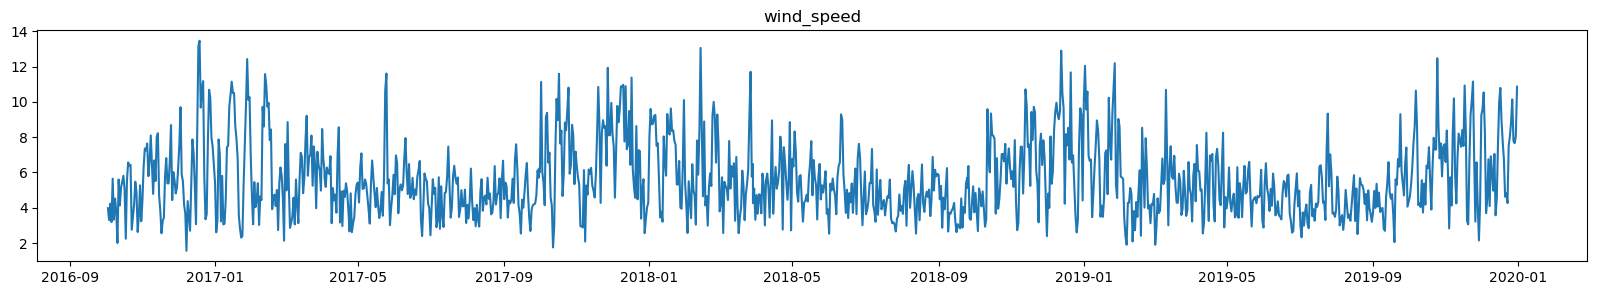

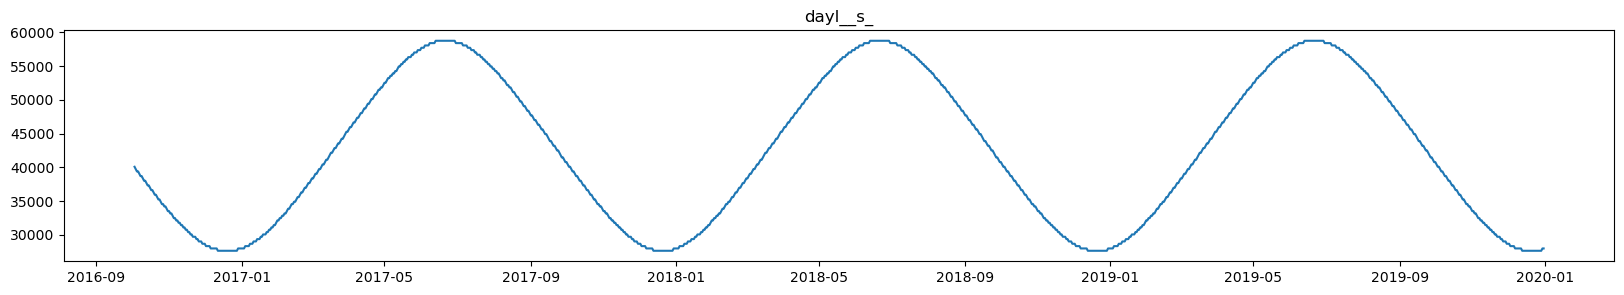

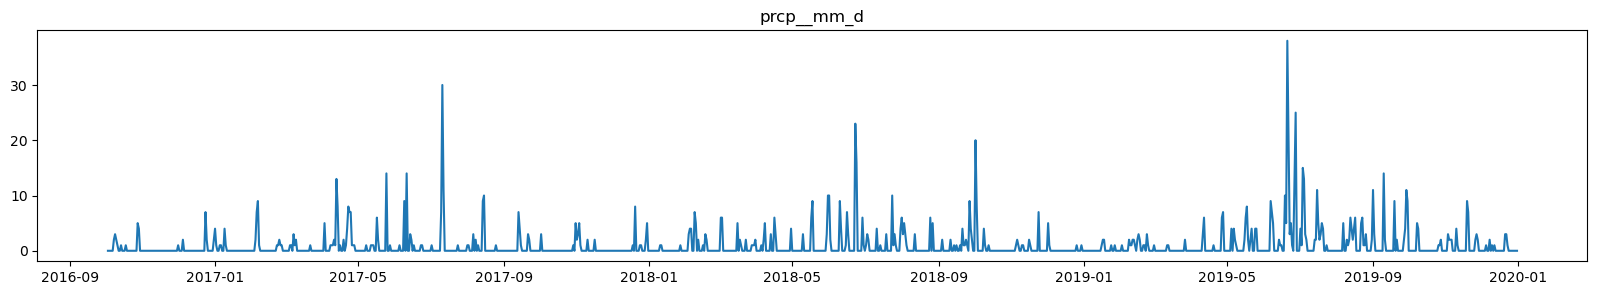

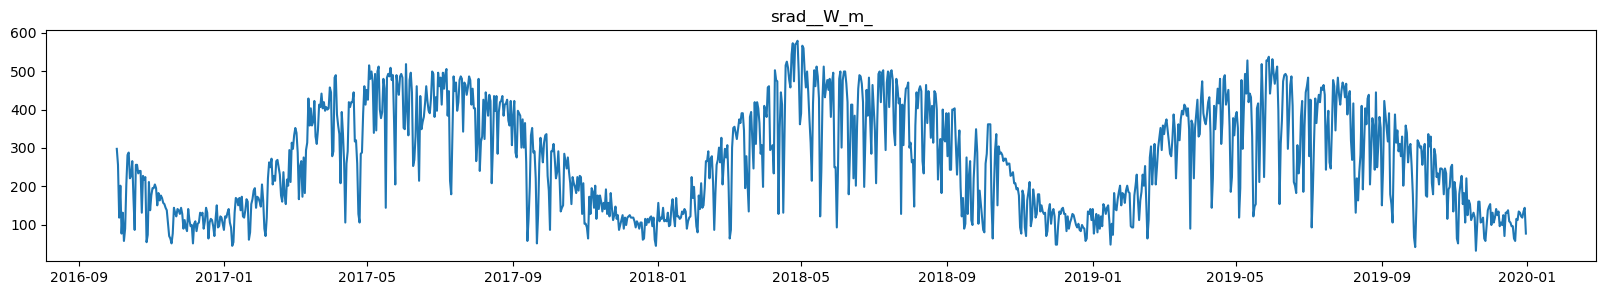

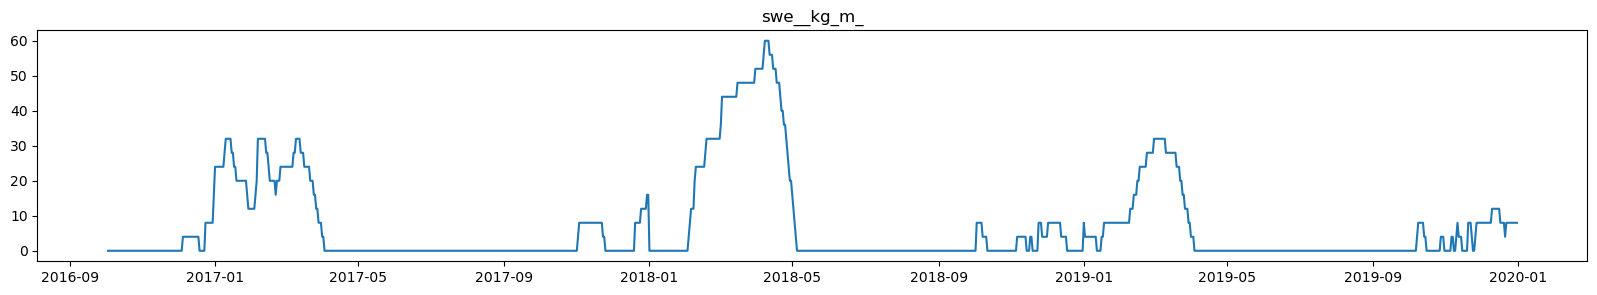

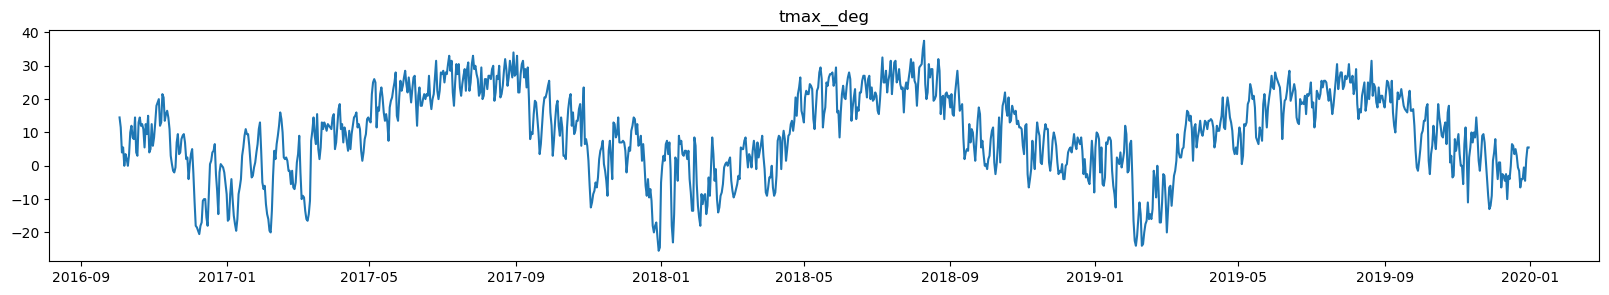

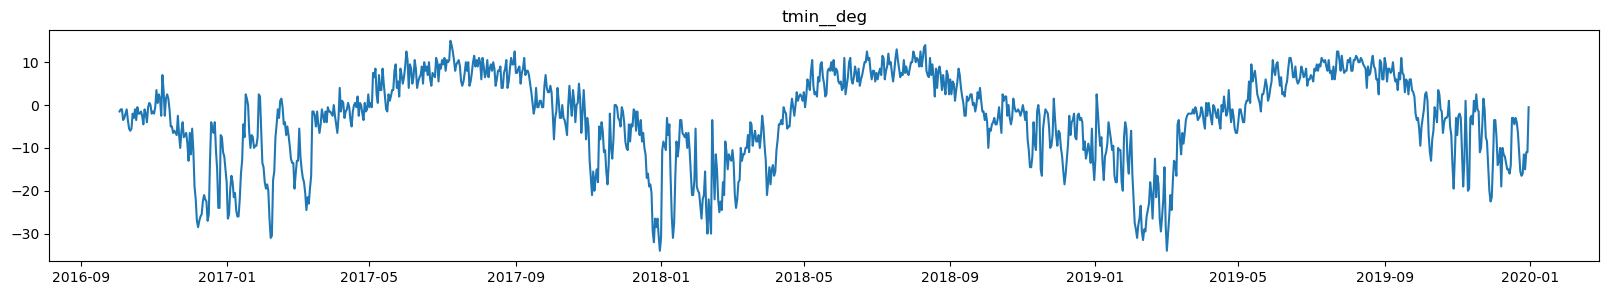

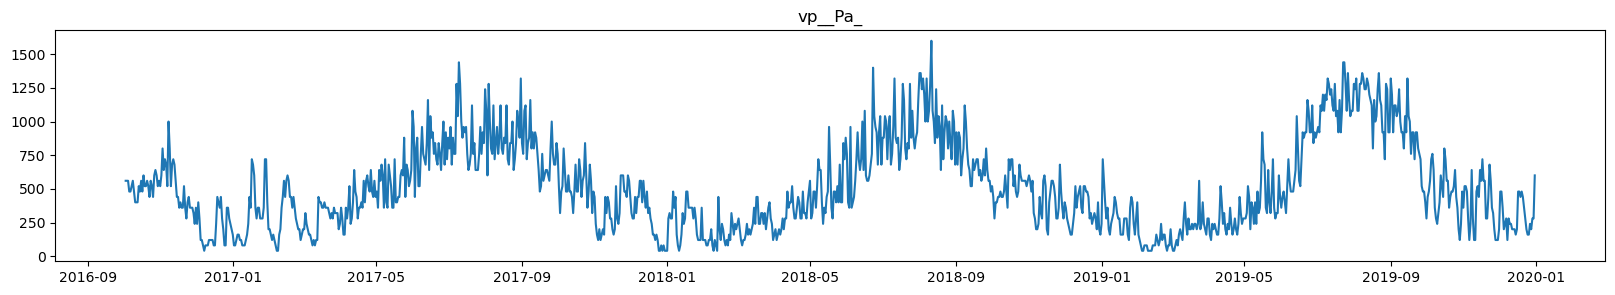

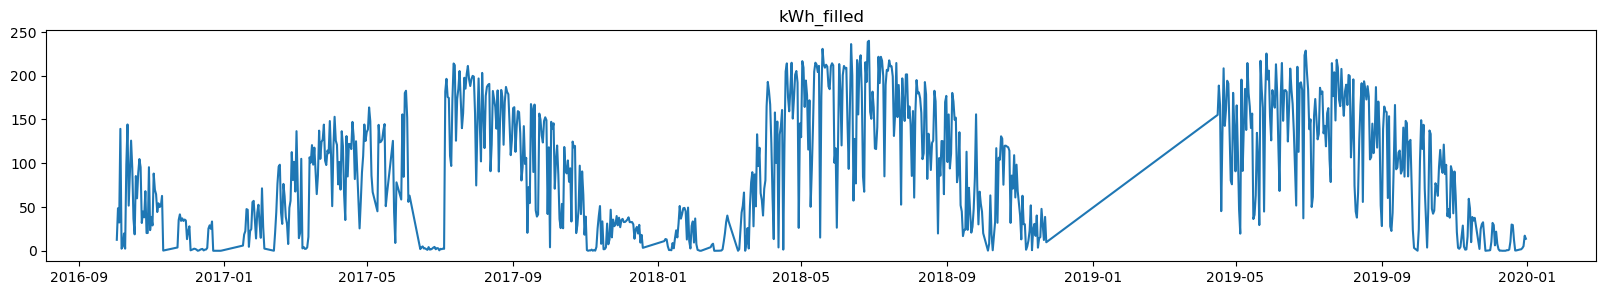

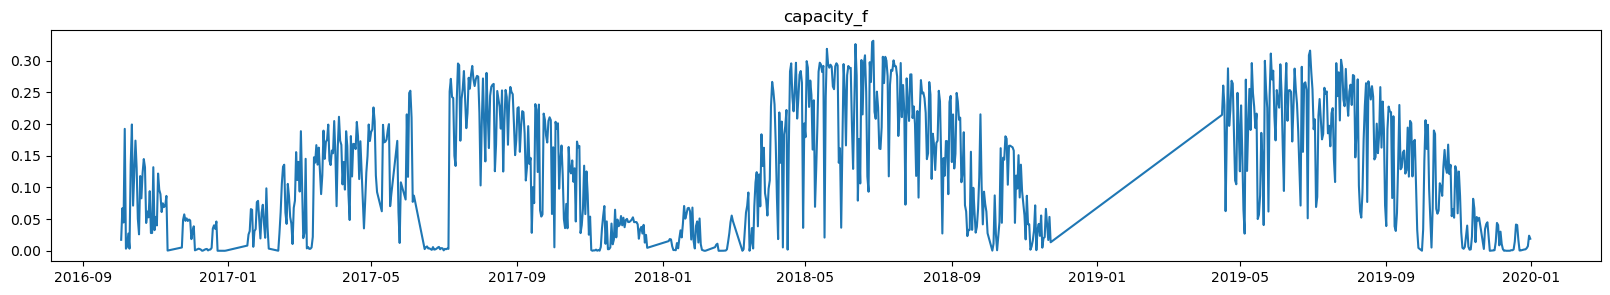

In [7]:
# plot and Visualize the variables from the training set for one solar station - Hillhurst Sunnyside Community Association 
hillhurst_solar = calgary_no_southland_solar_layer_sdf[calgary_no_southland_solar_layer_sdf['solar_plan']=='Hillhurst Sunnyside Community Association'].copy()
hillhurst_datetime = hillhurst_solar.set_index(hillhurst_solar['date'])
hillhurst_datetime = hillhurst_datetime.sort_index() 
for i in range(7,hillhurst_datetime.shape[1]-1):
        plt.figure(figsize=(20,3))
        plt.title(hillhurst_datetime.columns[i])
        plt.plot(hillhurst_datetime[hillhurst_datetime.columns[i]])
        plt.show()

In the above plots it can be seen that each of the variables has high seasonality and it seems that there is some relationship between the dependent variable of **kWh_filled** and the rest. Hence this is followed by creating a correlation plot to check the correlation between the variables. 

In [8]:
# checking the correlation matrix between the predictors and the dependent variable of capacity_factor
corr_test = calgary_no_southland_solar_layer_sdf.drop(['FID','date','ID','latitude','longitude','solar_plan','kWh_filled','SHAPE'], axis=1)
corr = corr_test.corr()
corr.style.background_gradient(cmap='Greens').format(precision=2)

The plot shows that the variable of shortwave radiation per meter square (**srad__W_m_**) received at the site has the maximum correlation with the dependent variable of total solar energy produced expressed in terms of capacity factor(**capacity_f**), which is self-explanatory. This is followed by the variable of day length(**dayl__s_**) which means that longer the day more the produced energy. These two are closely followed by max(**tmax__deg**) and min(**tmin__deg**) daily temperatures, and lastly the other variables.    

### Validation Set<a class="anchor" id="7"></a>

This set consists of daily solar generation data dated from September, 2015 to December, 2019 of one solar site known as Southland Leisure Centre for the purpose of validating the trained model:-

<Item title:"southland_solar" type:Feature Layer Collection owner:api_data_owner>
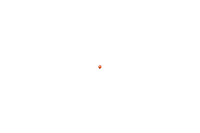

In [9]:
# Access the Southland Solar Plant Dataset feature layer for validation
southland_solar = gis.content.search('southland_solar owner:api_data_owner', 'feature layer')[0]
southland_solar

In [10]:
# Access the layer from the feature layer
southland_solar_layer = southland_solar.layers[0]


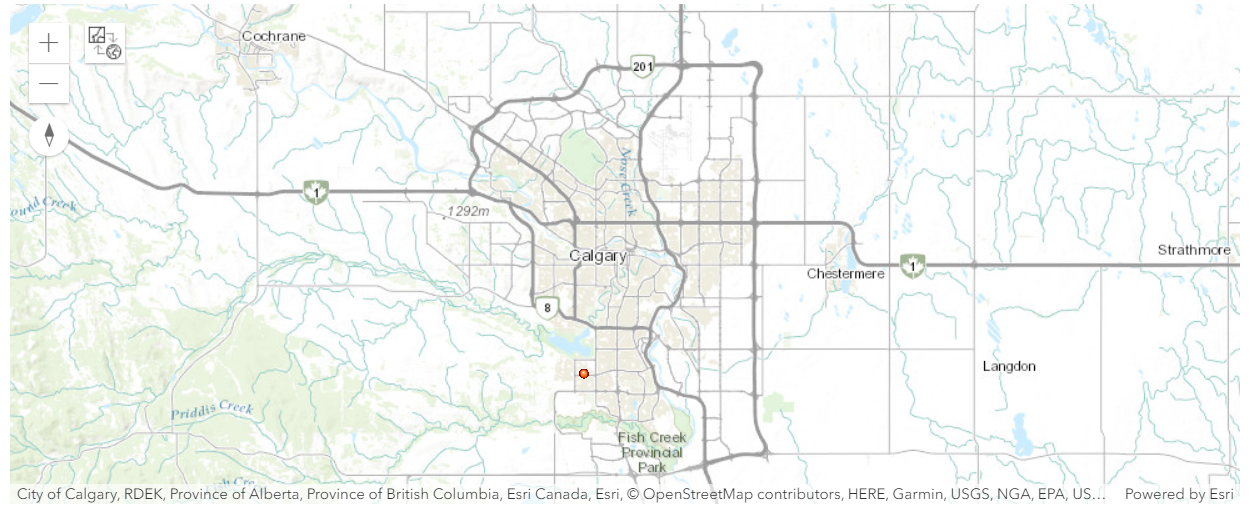

In [11]:
#  Plot location of the Southland Solar site in Calgary to be used for validation
m1 = gis.map('calgary')
m1.content.add(southland_solar_layer)
m1

In [12]:
# visualize the southland dataframe here
southland_solar_layer_sdf = southland_solar_layer.query().sdf
southland_solar_layer_sdf.head(2)

FID     Field1      ID                solar_plan  altitude_m   latitude  \
0    1 2019-10-03  164440  Southland Leisure Centre      1100.0  50.962485   
1    2 2019-10-04  164440  Southland Leisure Centre      1100.0  50.962485   

    longitude  wind_speed      dayl__s_  prcp__mm_d  ...  tmin__deg  vp__Pa_  \
0 -114.108472    5.332239  40089.601562         0.0  ...       -3.0    480.0   
1 -114.108472    6.304829  40089.601562         0.0  ...       -1.0    560.0   

   kWh_filled  capacity_f                              GlobalID  \
0     309.644    0.084326  e9b0f671-d6ba-4560-b912-d635a0a129f8   
1     679.785    0.185127  7bde5210-a8c2-4731-9c23-e5f77c1ebc56   

             CreationDate        Creator                EditDate  \
0 2020-04-27 11:58:02.992  arcgis_python 2020-04-27 11:58:02.992   
1 2020-04-27 11:58:02.992  arcgis_python 2020-04-27 11:58:02.992   

          Editor                                              SHAPE  
0  arcgis_python  {"x": -12702497.020502415, "y": 6614660.374377...  
1  arcgis_python  {"x": -12702497.020502415, "y": 6614660.374377...  

[2 rows x 23 columns]

In [13]:
# check the total number of samples
southland_solar_layer_sdf.shape

(1590, 23)

## Model Building <a class="anchor" id="9"></a>
Once the training and the validation dataset is processed and analyzed, it is ready to be used for modeling.

In this sample two types of methodology are used for modeling:

1) `FullyConnectedNetwork` - First a deep learning framework called `FullyConnectedNetwork` available in the `arcgis.learn` module in ArcGIS API for Python is used.

2) `MLModel` - In the second option, a regression model from scikit-learn is implemented via the `MLModel` framework in `arcgis.learn`. This framework can deploy any regression or classification model from the library just by passing the name of the algorithm and its relevant parameters as keyword arguments.


Finally, performance between the two methods will be compared in terms of model training and validation accuracy.



Further details on `FullyConnectedNetwork` & `MLModel` are available [here](https://developers.arcgis.com/python/guide/) in the Deep Learning with ArcGIS section.

### 1 — FullyConnectedNetwork <a class="anchor" id="10"></a>
This is an Artificial Neural Network model from the `arcgis.learn` module which is used here for modeling.

### Data Preprocessing <a class="anchor" id="11"></a>

First a list is made consisting of the feature data that will be used for predicting daily solar energy generation. By default, it will receive continuous variables, while in case of categorical variables the **True** value should be passed inside a tuple along with the variable. Here all the variables are continuous.

In [14]:
# Here a list is created naming all fields containing the predictors from the input feature layer
X = ['altitude_m', 'wind_speed', 'dayl__s_', 'prcp__mm_d','srad__W_m_','swe__kg_m_','tmax__deg','tmin__deg','vp__Pa_']

In [15]:
# importing the libraries from arcgis.learn for data preprocessing
from arcgis.learn import prepare_tabulardata

Once the explanatory variables are identified the main preprocessing of the data is carried out by the `prepare_tabulardata` method from the `arcgis.learn` module in the ArcGIS API for Python. The function takes a feature layer or a spatial dataframe containing the dataset as input and  returns a TabularDataObject that can be fed into the model. 

The input parameters required for the tool are:

- <span style='background :lightgrey' >input_features</span> : feature layer or spatial dataframe having the primary dataset
- <span style='background :lightgrey' >variable_predict</span> : field name containing the y-variable from the input feature layer/dataframe
- <span style='background :lightgrey' >explanatory_variables</span> : list of the field names as 2-sized tuples containing the explanatory variables as mentioned above

In [16]:
# precrocessing data using prepare data method - it handles imputing missing values, normalization and train-test split
data = prepare_tabulardata(calgary_no_southland_solar_layer,
                           'capacity_f',
                           explanatory_variables=X)

In [17]:
# visualizing the prepared data 
data.show_batch()

altitude_m  capacity_f      dayl__s_  prcp__mm_d  srad__W_m_  \
1640        1055    0.106612  37324.800781           0  281.600006   
1788        1095    0.070813  55641.601562           7       144.0   
1825        1095    0.224948       58752.0           1  387.200012   
4140        1070    0.016279  40780.800781           0  300.799988   
7897        1096    0.237411  50457.601562           0  441.600006   

      swe__kg_m_  tmax__deg  tmin__deg  vp__Pa_  wind_speed  
1640           0       18.5        3.5      800    6.391703  
1788           0        7.5        2.5      720    5.120847  
1825           0       20.0        7.5      880    3.322512  
4140          36      -11.0      -19.5      120    3.128044  
7897           0       27.0        4.0      680    4.591178

### Model Initialization <a class="anchor" id="12"></a>

Once the data has been prepared by the `prepare_tabulardata` method it is ready to be passed to the ANN for training. First the ANN known as `FullyConnectedNetwork` is imported from `arcgis.learn` and initialized as follows:

In [18]:
# importing the model from arcgis.learn
from arcgis.learn import FullyConnectedNetwork

In [19]:
# Initialize the model with the data where the weights are randomly allocated 
fcn = FullyConnectedNetwork(data, layers=[200,130])

### Learning Rate Search<a class="anchor" id="13"></a>

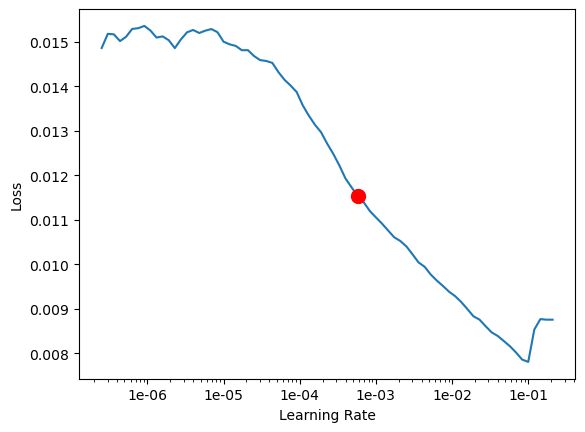

0.0005754399373371565

In [20]:
# searching for an optimal learning rate using the lr_find for passing it to the final model fitting 
lr = fcn.lr_find()
lr

Here the suggested learning rate by the `lr_find` method is around 0.0012. The automatic lr_finder will take a conservative estimate of the learning rate, but some experts can interpret the graph more appropriately and find a better learning rate to be used for final training of the model.

### Model Training <a class="anchor" id="14"></a>

Finally the model is now ready for training, and the `model.fit` method is used which is given the number of epochs for training and the estimated learning rate selected based on the `lr_find` returned in the previous step:

In [21]:
# the model is trained for 100 epochs 
fcn.fit(100, lr=lr)

The train vs valid losses is plotted to check if the model is overfitting. It shows that the model has trained well and though the losses are still gradually decreasing but not significantly. 

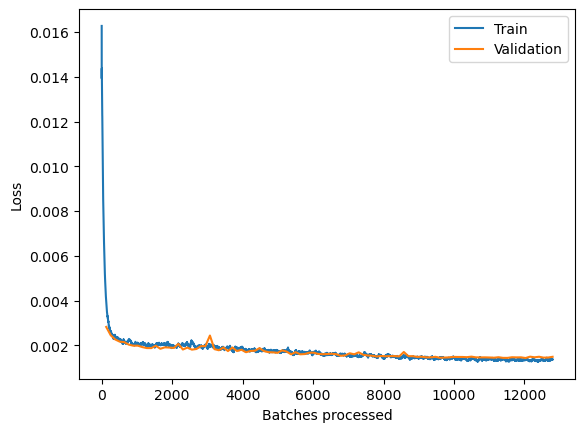

In [22]:
# the train vs valid losses is plotted to check quality of the trained model
fcn.plot_losses()

Finally, the training results are printed to assess the prediction on the test set by the trained model.

In [23]:
# the predicted values by the trained model is printed for the test set
fcn.show_results()

altitude_m  capacity_f      dayl__s_  prcp__mm_d  srad__W_m_  \
3150        1095    0.256616  58406.398438           0       480.0   
158         1095    0.120955  35942.398438           0       240.0   
5927        1070    0.288044       58752.0           2  470.399994   
7428        1094     0.08343       58752.0          23  201.600006   
8900        1051    0.007171  41126.398438          11   41.599998   

      swe__kg_m_  tmax__deg  tmin__deg  vp__Pa_  wind_speed  \
3150           0       22.0        6.0      520    3.570236   
158            0       13.0       -3.0      480    7.964495   
5927           0       23.0        6.5      560    3.339548   
7428           0       20.5       12.5     1360    6.224127   
8900           0       -1.5       -3.0      480    7.412553   

      prediction_results  
3150            0.205817  
158             0.124888  
5927            0.243402  
7428            0.111588  
8900            0.001019

In the above table, the predicted values by the model on the test set in the last column named **prediction_results** and the actual values in the column named **capacity_f** of the target variable are highly similar. 

Accordingly, the model metrics of the trained model is now estimated using the `model.score` function. It returns the r-square of the model fit as follows: 

In [24]:
# the model.score method from the tabular learner returns r-square
r_Square_fcn_test = fcn.score() 
print('r_Square_fcn_test: ', round(r_Square_fcn_test,5))

r_Square_fcn_test:  0.84108


The high r-square value indicates that the model has been trained well 

### Solar Energy Generation Forecast & Validation <a class="anchor" id="15"></a>

The trained model(`FullyConnectedNetwork`) will now be used to predict the daily lifetime solar energy generation for the solar plant installed at the Southland Leisure Centre since it was installed during 2015. The aim is to validate the trained model and measure its performance of solar output estimation using only weather variables from the Southland Leisure Center. 

Accordingly the `model.predict` method from `arcgis.learn` is used with the daily weather variables as input for the mentioned site ranging from September, 2015 to December, 2019 to predict daily solar energy output in KWh for the same time period. The predictors are automatically chosen from the input feature layer of [southland_layer](#7) by the trained model without mentioning them explicitly, since their names are exactly same as used during training the model.  

In [25]:
# predicting using the predict function 
southland_solar_layer_predicted = fcn.predict(southland_solar_layer, output_layer_name='prediction_layer')

In [26]:
# print the predicted layer
southland_solar_layer_predicted

<Item title:"prediction_layer" type:Feature Layer Collection owner:api_data_owner>

In [27]:
# Access & visualize the dataframe from the predicted layer 
test_pred_layer = southland_solar_layer_predicted.layers[0]
test_pred_layer_sdf = test_pred_layer.query().sdf
test_pred_layer_sdf.head()

FID   FID_1     Field1      ID                solar_plan  altitude_m  \
0    1  1201.0 2018-09-10  164440  Southland Leisure Centre      1100.0   
1    2  1202.0 2018-09-11  164440  Southland Leisure Centre      1100.0   
2    3  1203.0 2018-09-12  164440  Southland Leisure Centre      1100.0   
3    4  1204.0 2018-09-13  164440  Southland Leisure Centre      1100.0   
4    5  1205.0 2018-09-14  164440  Southland Leisure Centre      1100.0   

    latitude   longitude  wind_speed      dayl__s_  ...        Creator  \
0  50.962485 -114.108472     3.71462  45619.199219  ...  arcgis_python   
1  50.962485 -114.108472    3.663262  45619.199219  ...  arcgis_python   
2  50.962485 -114.108472    3.847847  45273.601562  ...  arcgis_python   
3  50.962485 -114.108472    3.958236       44928.0  ...  arcgis_python   
4  50.962485 -114.108472    4.275449  44582.398438  ...  arcgis_python   

    EditDate         Editor         zone3_id         zone4_id  \
0 2020-04-27  arcgis_python  8312ccfffffffff  8412ccdffffffff   
1 2020-04-27  arcgis_python  8312ccfffffffff  8412ccdffffffff   
2 2020-04-27  arcgis_python  8312ccfffffffff  8412ccdffffffff   
3 2020-04-27  arcgis_python  8312ccfffffffff  8412ccdffffffff   
4 2020-04-27  arcgis_python  8312ccfffffffff  8412ccdffffffff   

          zone5_id         zone6_id         zone7_id prediction  \
0  8512ccc3fffffff  8612ccd57ffffff  8712ccd52ffffff   0.129638   
1  8512ccc3fffffff  8612ccd57ffffff  8712ccd52ffffff   0.149016   
2  8512ccc3fffffff  8612ccd57ffffff  8712ccd52ffffff     0.0457   
3  8512ccc3fffffff  8612ccd57ffffff  8712ccd52ffffff    0.04043   
4  8512ccc3fffffff  8612ccd57ffffff  8712ccd52ffffff   0.046646   

                                               SHAPE  
0  {"x": -12702497.020502415, "y": 6614660.374377...  
1  {"x": -12702497.020502415, "y": 6614660.374377...  
2  {"x": -12702497.020502415, "y": 6614660.374377...  
3  {"x": -12702497.020502415, "y": 6614660.374377...  
4  {"x": -12702497.020502415, "y": 6614660.374377...  

[5 rows x 30 columns]

In [28]:
test_pred_layer_sdf.shape

(1590, 30)

The table above returns the predicted values for the Southland photovoltaic power plant stored in the field called **prediction_results** which has the model estimated daily capacity factor of energy generation, whereas the actual capacity factor is in the field named **capacity_f**.

The capacity factor is a normalized value which is now rescaled back to the original unit of KWh in the following, using the peak capacity of the Southland photovoltaic power plant which is 153KWp.   

In [29]:
test_pred_layer_sdf.columns

Index(['FID', 'FID_1', 'Field1', 'ID', 'solar_plan', 'altitude_m', 'latitude',
       'longitude', 'wind_speed', 'dayl__s_', 'prcp__mm_d', 'srad__W_m_',
       'swe__kg_m_', 'tmax__deg', 'tmin__deg', 'vp__Pa_', 'kWh_filled',
       'capacity_f', 'GlobalID', 'CreationDa', 'Creator', 'EditDate', 'Editor',
       'zone3_id', 'zone4_id', 'zone5_id', 'zone6_id', 'zone7_id',
       'prediction', 'SHAPE'],
      dtype='object')

In [30]:
optional_columns = ['prediction_results','prediction']

pred_col = None 
for opt_col in optional_columns:
    if opt_col in test_pred_layer_sdf.columns:
        pred_col = opt_col
        break

In [31]:
# inverse scaling from capacity factor to actual generation in KWh  - peak capacity of Southland Leisure Centre is 153KWp
test_pred_datetime = test_pred_layer_sdf[['Field1','capacity_f',pred_col]].copy()
test_pred_datetime = test_pred_datetime.rename(columns={'Field1':'date'})
test_pred_datetime['date'] = pd.to_datetime(test_pred_datetime['date']) 
test_pred_datetime = test_pred_datetime.set_index(test_pred_datetime['date'])
test_pred_datetime['Actual_generation(KWh)'] = test_pred_datetime['capacity_f']*24*153
test_pred_datetime['predicted_generation(KWh)'] = test_pred_datetime[pred_col]*24*153
test_pred_datetime = test_pred_datetime.drop(['date','capacity_f',pred_col], axis=1).sort_index() 
test_pred_datetime

Actual_generation(KWh)  predicted_generation(KWh)
date                                                         
2015-09-01                 286.013                 645.847283
2015-09-02                 681.646                  573.81391
2015-09-03                 647.906                 550.952354
2015-09-04                 102.448                 188.131957
2015-09-05                  93.432                 105.872621
...                            ...                        ...
2019-12-27                   1.349                  40.980099
2019-12-28                   1.965                  22.588846
2019-12-29                   1.616                   74.11202
2019-12-30                    7.44                 110.594964
2019-12-31                   8.323                  57.998556

[1590 rows x 2 columns]

The table above shows the actual versus the model predicted daily solar energy generated for the Southland plant for the duration of late 2015 to the end of 2019. These values are now used to estimate the various model metrics to understand the prediction power of the model. 

In [32]:
# estimate model metrics of r-square, rmse and mse for the actual and predicted values for daily energy generation
from sklearn.metrics import r2_score
r2_test = r2_score(test_pred_datetime['Actual_generation(KWh)'],test_pred_datetime['predicted_generation(KWh)'])
print('R-Square: ', round(r2_test, 2))

R-Square:  0.86


The comparison returns a considerably high r-square of 0.86 showing high similarity between actual and predicted values.

In [32]:
# Comparison between the actual sum of the total energy generated to the total predicted values 
actual = (test_pred_datetime['Actual_generation(KWh)'].sum()/4/1000).round(2)  
predicted = (test_pred_datetime['predicted_generation(KWh)'].sum()/4/1000).round(2) 
print('Actual annual Solar Energy Generated by Southland Solar Station: {} MWh'.format(actual))
print('Predicted annual Solar Energy Generated by Southland Solar Stations: {} MWh'.format(predicted))

Actual annual Solar Energy Generated by Southland Solar Station: 170.03 MWh
Predicted annual Solar Energy Generated by Southland Solar Stations: 170.44 MWh


## Result Visualization<a class="anchor" id="16"></a>

Finally, the actual and predicted values are plotted to visualize their distribution across the entire lifetime of the power plant. 

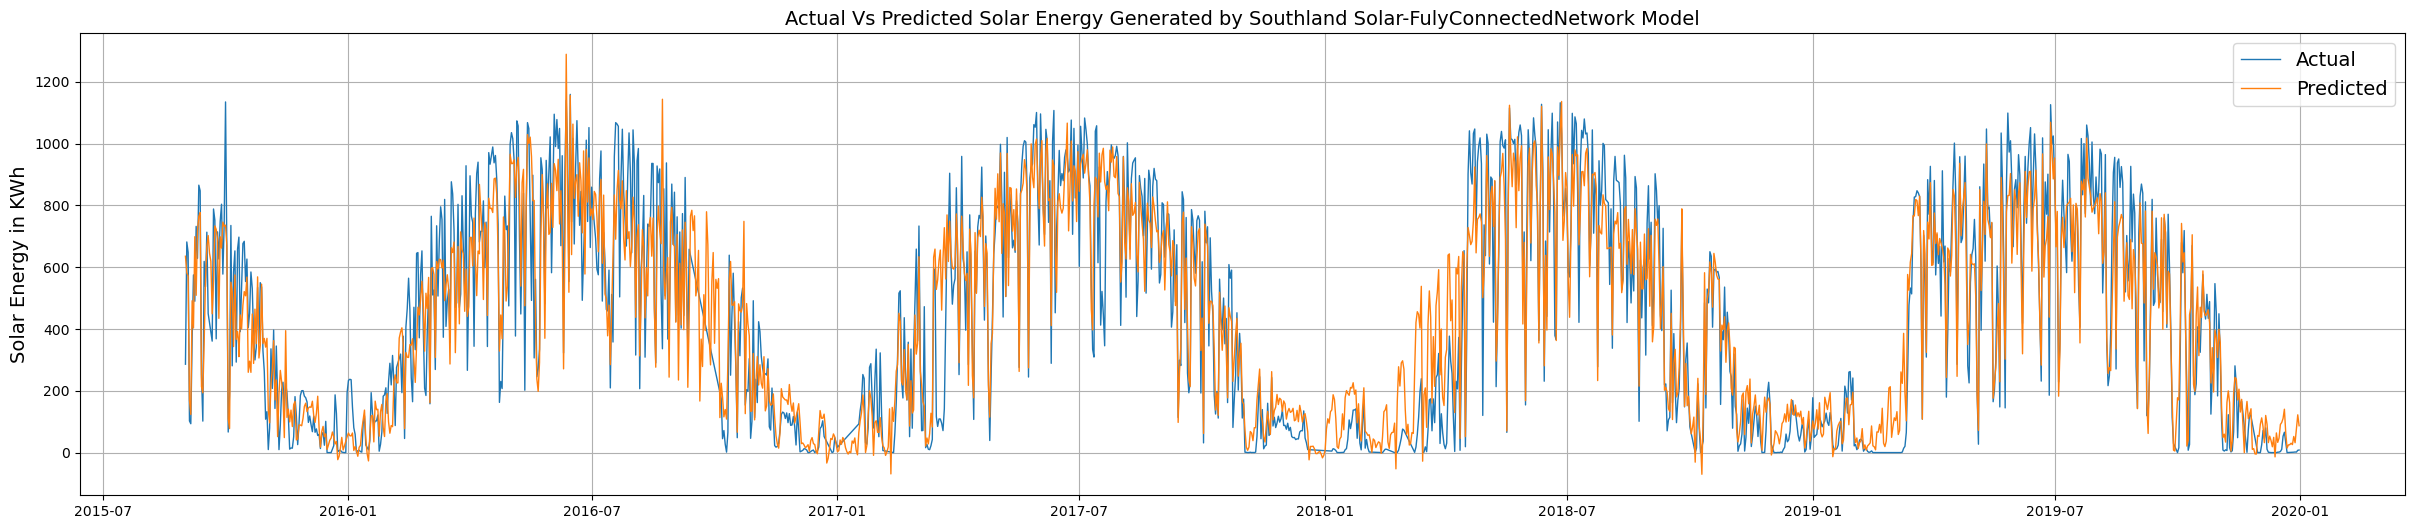

In [33]:
plt.figure(figsize=(30,6))
plt.plot(test_pred_datetime['Actual_generation(KWh)'],  linewidth=1, label= 'Actual') 
plt.plot(test_pred_datetime['predicted_generation(KWh)'], linewidth=1, label= 'Predicted')  
plt.ylabel('Solar Energy in KWh', fontsize=14)
plt.legend(fontsize=14,loc='upper right')
plt.title('Actual Vs Predicted Solar Energy Generated by Southland Solar-FulyConnectedNetwork Model', fontsize=14)
plt.grid()
plt.show() 

Summarizing the values, it is seen that the actual average annual energy generated by the solar plant is very close to the predicted annual average generated energy which reveals high precision. 

In the plot above the blue line indicates the actual generation and the orange line shows the predicted values, both of which overlaps each other to a high degree, showing a high predictive capacity of the model.

### MLModel <a class="anchor" id="17"></a>
In the second methodology a machine learning model is applied to model the same data using the `MLModel` framework from `arcgis.learn`. This framework could be used to import and apply any machine learning model from the scikit-learn library on the data returned by the `prepare_tabulardata` function from `arcgis.learn`.

In [34]:
# importing the libraries from arcgis.learn for data preprocessing for the Machine Learning Model
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler  
from sklearn.compose import make_column_transformer 

### Data Preprocessing<a class="anchor" id="18"></a>

Like the data preparation process for the neural network, first a list is made consisting of the feature data that will be used for predicting daily solar energy generation. By default, it will receive continuous variables, whereas for categorical variables the **True** value should be passed inside a tuple along with the variables. These variables are then transformed by the  RobustScaler function from scikit-learn by passing it along with the variable list into the column transformer function as follows:  

In [35]:
# scaling the feature data using MinMaxScaler(), the default is Normalizer from scikit learn
X = ['altitude_m', 'wind_speed', 'dayl__s_', 'prcp__mm_d','srad__W_m_','swe__kg_m_','tmax__deg','tmin__deg','vp__Pa_']
numerical_transformer = make_pipeline(MinMaxScaler())
preprocessors = make_column_transformer((numerical_transformer, X))

Once the explanatory variables list is defined and the precrocessors are computed these are now used as input for the `prepare_tabulardata` method in  `arcgis.learn`. The method takes a feature layer or a spatial dataframe containing the dataset and returns a TabularDataObject that can be fed into the model.  

The input parameters required for the tool are similar to the ones mentioned previously:

In [36]:
# importing the library from arcgis.learn for prepare data
from arcgis.learn import prepare_tabulardata

In [37]:
# precrocessing data using prepare data method for MLModel
data = prepare_tabulardata(calgary_no_southland_solar_layer,
                           'capacity_f',
                           explanatory_variables=X,                           
                           preprocessors=preprocessors)

### Model Initialization <a class="anchor" id="19"></a>

Once the data has been prepared by the `prepare_tabulardata` method it is ready to be passed to the selected machine learning model for training. Here the GradientBoostingRegressor model from scikit-learn is used which is passed into the `MLModel` function, along with its parameters as follows:

In [38]:
# importing the MLModel framework from arcgis.learn and the model from scikit learn 
from arcgis.learn import MLModel

# defining the model along with the parameters 
model = MLModel(data, 'sklearn.ensemble.GradientBoostingRegressor',loss ='absolute_error', learning_rate=0.02, n_estimators=117, random_state=43)

### Model Training <a class="anchor" id="20"></a>

Finally, the model is now ready for training, and the `model.fit` method is used for fitting the machine learning model with its defined parameters mentioned in the previous step.

In [39]:
model.fit()

The training results are printed to compute some model metrics and assess the quality of the trained model.

In [40]:
model.show_results()

altitude_m  capacity_f      dayl__s_  prcp__mm_d  srad__W_m_  \
1489        1055    0.019555       29376.0           0        96.0   
3502        1112    0.253015       53568.0           0  473.600006   
4304        1070    0.248061       50112.0           0  422.399994   
5491        1090    0.018597  34905.601562           0  265.600006   
7679        1096    0.112015  44582.398438           0       288.0   

      swe__kg_m_  tmax__deg  tmin__deg  vp__Pa_  wind_speed  \
1489           0       -4.5      -12.0      240    5.819128   
3502           0       24.5        8.0      680    5.097813   
4304           0       29.0        7.5      800    3.733651   
5491          28        3.0      -14.5      200    8.435382   
7679           0       22.5       10.5     1280    4.886889   

      capacity_f_results  
1489            0.015684  
3502            0.227703  
4304            0.213505  
5491            0.047954  
7679            0.152136

In the above table the last column named **capacity_f_results** returns the predicted values by the model on the test set which is highly similar to the actual values in the column named **capacity_f** for the target variable. 

Subsequently, the model metrics of the trained model is now estimated using the `model.score()` function which currently returns the r-square of the model fit as follows: 

In [41]:
# r-square is estimated using the inbuilt model.score() from the tabular learner
print('r_square_test_rf: ', round(model.score(), 5))

r_square_test_rf:  0.76784


The high R-squared value indicates that the model has been trained well.

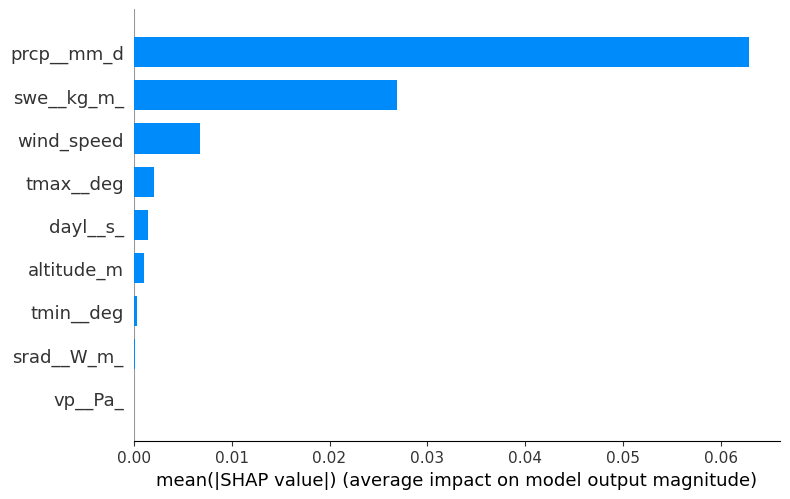

In [42]:
feature_imp_RF = model.feature_importances_

### Solar Energy Generation Forecast & Validation<a class="anchor" id="21"></a>

The trained GradientBoostingRegressor model implemented via the `MLModel` will now be used to predict the daily lifetime solar energy generation for the solar plant installed at the Southland Leisure Centre similarly since it was installed during 2015. The aim is to compare and validate its performance as obtained by the `FullyConnectedNetwork` model.

To recapitulate the `model.predict` method from `arcgis.learn` is used with the daily weather variables as input for the mentioned site ranging from September, 2015 to December, 2019 to predict daily solar energy output in KWh for the same time period. The predictors are automatically chosen from the input feature layer of [southland_layer](#7) by the trained model without mentioning them explicitly, since their names are exactly same as are used for training the model.  

In [43]:
southland_solar_layer_predicted_rf = model.predict(southland_solar_layer, output_layer_name='prediction_layer_rf')

In [44]:
# print the predicted layer
southland_solar_layer_predicted_rf

<Item title:"prediction_layer_rf" type:Feature Layer Collection owner:api_data_owner>

In [45]:
# Access & visualize the dataframe from the predicted layer 
valid_pred_layer = southland_solar_layer_predicted_rf.layers[0]
valid_pred_layer_sdf = valid_pred_layer.query().sdf
valid_pred_layer_sdf.head()

FID  FID_1     Field1      ID                solar_plan  altitude_m  \
0    1  401.0 2016-07-05  164440  Southland Leisure Centre      1100.0   
1    2  402.0 2016-07-06  164440  Southland Leisure Centre      1100.0   
2    3  403.0 2016-07-07  164440  Southland Leisure Centre      1100.0   
3    4  404.0 2016-07-08  164440  Southland Leisure Centre      1100.0   
4    5  405.0 2016-07-09  164440  Southland Leisure Centre      1100.0   

    latitude   longitude  wind_speed      dayl__s_  ...  vp__Pa_  kWh_filled  \
0  50.962485 -114.108472    3.787571  58060.800781  ...    920.0     593.275   
1  50.962485 -114.108472     3.30231  58060.800781  ...    920.0     575.397   
2  50.962485 -114.108472    3.923609  58060.800781  ...    880.0     886.423   
3  50.962485 -114.108472     4.37531  57715.199219  ...   1000.0     976.136   
4  50.962485 -114.108472    2.816725  57715.199219  ...   1000.0      490.25   

   capacity_f                              GlobalID  CreationDa  \
0    0.161567  3cbc6ed1-6504-4f41-8e4b-b95c62816070  2020-04-27   
1    0.156699  d19858dc-1caa-4893-9e98-1540753eec4a  2020-04-27   
2    0.241401  0ede54fa-3541-45be-9b64-5cdf259f69aa  2020-04-27   
3    0.265832  c7259240-55a6-40fe-8700-844fafc12b8f  2020-04-27   
4     0.13351  6e59869a-e4e3-473a-b98f-a57ec6a5b480  2020-04-27   

         Creator   EditDate         Editor prediction  \
0  arcgis_python 2020-04-27  arcgis_python    0.15771   
1  arcgis_python 2020-04-27  arcgis_python   0.206897   
2  arcgis_python 2020-04-27  arcgis_python   0.222833   
3  arcgis_python 2020-04-27  arcgis_python   0.221457   
4  arcgis_python 2020-04-27  arcgis_python   0.205337   

                                               SHAPE  
0  {"x": -12702497.020502415, "y": 6614660.374377...  
1  {"x": -12702497.020502415, "y": 6614660.374377...  
2  {"x": -12702497.020502415, "y": 6614660.374377...  
3  {"x": -12702497.020502415, "y": 6614660.374377...  
4  {"x": -12702497.020502415, "y": 6614660.374377...  

[5 rows x 25 columns]

The table above returns the `MLModel` predicted values for the Southland plant stored in the field **prediction** whereas the actual capacity factor is in the field named **capacity_f**.

The capacity factor is a normalized value which is now rescaled back to the original unit of KWh in the following, using the peak capacity of the Southland photovoltaic power plant which is 153KWp.

In [46]:
valid_pred_layer_sdf.columns

Index(['FID', 'FID_1', 'Field1', 'ID', 'solar_plan', 'altitude_m', 'latitude',
       'longitude', 'wind_speed', 'dayl__s_', 'prcp__mm_d', 'srad__W_m_',
       'swe__kg_m_', 'tmax__deg', 'tmin__deg', 'vp__Pa_', 'kWh_filled',
       'capacity_f', 'GlobalID', 'CreationDa', 'Creator', 'EditDate', 'Editor',
       'prediction', 'SHAPE'],
      dtype='object')

In [47]:
# inverse scaling from capcacity factor to actual generation in KWh  - peak capcity of Southland Leisure Centre is 153KWp
valid_pred_datetime = valid_pred_layer_sdf[['Field1','capacity_f',pred_col]].copy()
valid_pred_datetime = valid_pred_datetime.rename(columns={'Field1':'date'})
valid_pred_datetime['date'] = pd.to_datetime(valid_pred_datetime['date']) 
valid_pred_datetime = valid_pred_datetime.set_index(valid_pred_datetime['date'])
valid_pred_datetime['Actual_generation(KWh)'] = valid_pred_datetime['capacity_f']*24*153
valid_pred_datetime['predicted_generation(KWh)'] = valid_pred_datetime[pred_col]*24*153
valid_pred_datetime = valid_pred_datetime.drop(['date','capacity_f',pred_col], axis=1)
valid_pred_datetime = valid_pred_datetime.sort_index() 
valid_pred_datetime.head()

Actual_generation(KWh)  predicted_generation(KWh)
date                                                         
2015-09-01                 286.013                 736.742935
2015-09-02                 681.646                 673.932795
2015-09-03                 647.906                 516.336426
2015-09-04                 102.448                  200.73517
2015-09-05                  93.432                 179.647032

The table above shows the actual versus the `MLModel` predicted daily solar energy generated for the Southland plant for the duration of late 2015 to the end of 2019. These values are now used to estimate the various model metrics to understand the prediction power of the `MLModel`. 

In [48]:
# estimate model metrics of r-square, rmse and mse for the actual and predicted values for daily energy generation
from sklearn.metrics import r2_score
r2_test = r2_score(valid_pred_datetime['Actual_generation(KWh)'],valid_pred_datetime['predicted_generation(KWh)'])
print('R-Square: ', round(r2_test, 2))

R-Square:  0.81


The comparison returns a considerably high R-squared showing high similarity between actual and predicted values.

In [49]:
# Comparison between the actual sum of the total energy generated to the total predicted values by the MLModel 
actual = (valid_pred_datetime['Actual_generation(KWh)'].sum()/4/1000).round(2)  
predicted = (valid_pred_datetime['predicted_generation(KWh)'].sum()/4/1000).round(2) 
print('Actual annual Solar Energy Generated by Southland Solar Station: {} MWh'.format(actual))
print('Predicted annual Solar Energy Generated by Southland Solar Stations: {} MWh'.format(predicted))

Actual annual Solar Energy Generated by Southland Solar Station: 170.03 MWh
Predicted annual Solar Energy Generated by Southland Solar Stations: 170.04 MWh


Summarizing the values, it is seen that the actual average annual energy generated by the solar plant is very close to the predicted annual average generated energy which reveals high precision.

## Result Visualization<a class="anchor" id="22"></a>

Finally, the actual and predicted values are plotted to visualize their distribution across the entire lifetime of the power plant.

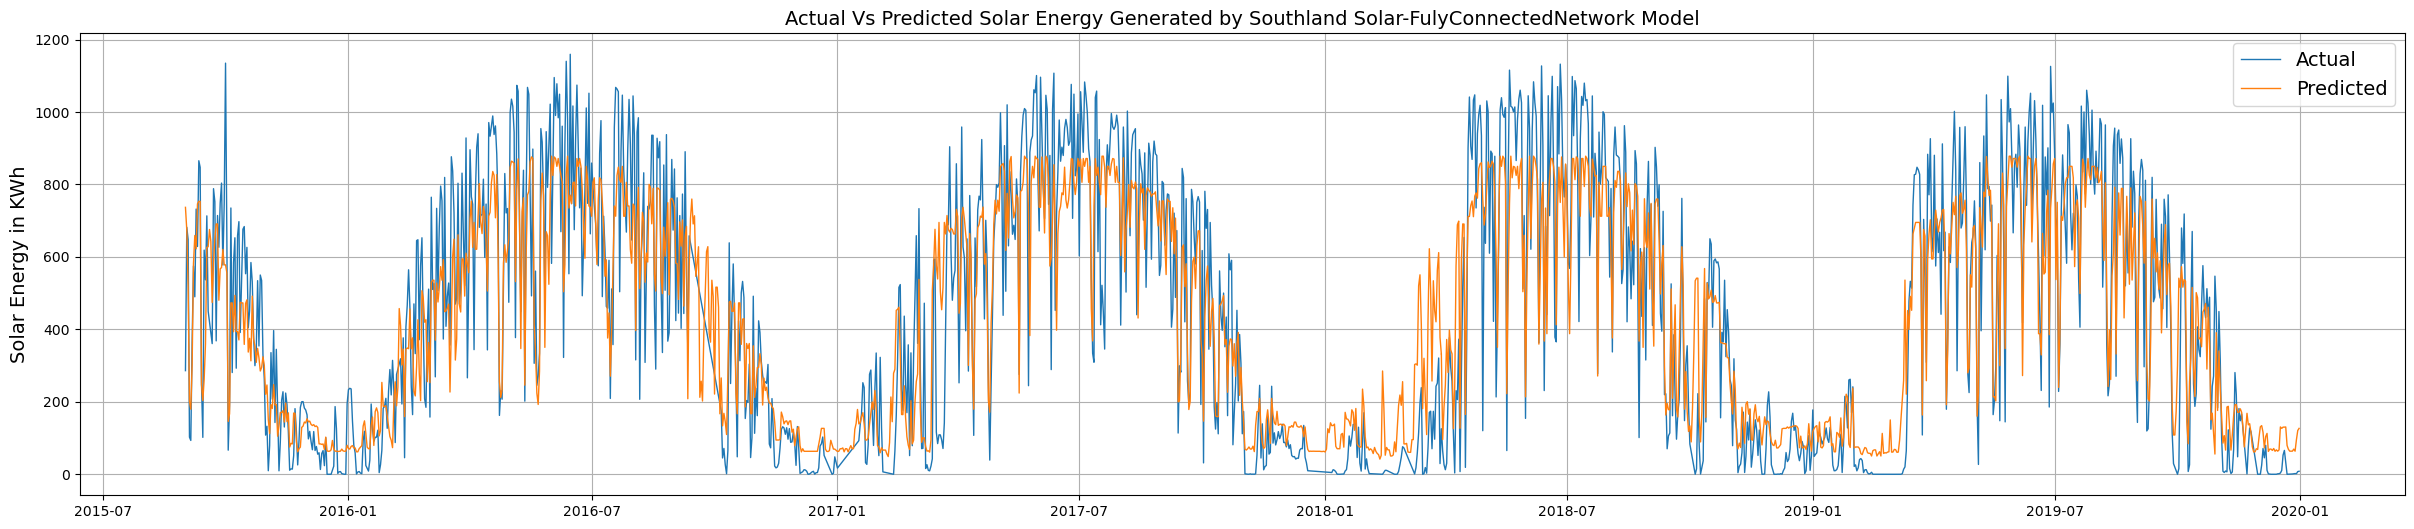

In [50]:
plt.figure(figsize=(30,6))
plt.plot(valid_pred_datetime['Actual_generation(KWh)'],  linewidth=1, label= 'Actual') 
plt.plot(valid_pred_datetime['predicted_generation(KWh)'], linewidth=1, label= 'Predicted')  
plt.ylabel('Solar Energy in KWh', fontsize=14)
plt.legend(fontsize=14,loc='upper right')
plt.title('Actual Vs Predicted Solar Energy Generated by Southland Solar-FulyConnectedNetwork Model', fontsize=14)
plt.grid()
plt.show() 

## Conclusion<a class="anchor" id="23"></a>

The goal of the project is to create a model that could predict the daily solar energy efficiency hence actual output of a photovoltaic solar plant at a location using daily weather variables of the site as input, and thereby demonstrate the application of the newly implemented artificial neural network of `FullyConnectedNetwork` and machine learning models called `MLModel` available in the `arcgis.learn` module in ArcGIS API for Python. 

Accordingly, data from 10 solar energy installation sites in the City of Calgary in Canada are used to train two different models — first the `FullyConnectedNetwork` model and second the `MLModel` framework from the `arcgis.learn` module. These were eventually used to predict the daily solar output of a different solar plant in Calgary which is held out from the training set. The steps for implementing these models are discussed and elaborated in the notebook including data preprocessing, model training and final inferencing.  

Comparison of the result shows that both the models successfully predicted the solar energy output of the test solar plant with predicted values of 171.76 MWh and 171.51 MWh by the `FullyConnectedNetwork` and the `MLModel` algorithm respectively, compared to the actual value of average annual solar generation of 170.74 MWh for the station.

Finally going further, it would be interesting to apply this model on other solar generation plants located across different geographies and record its performances to understand the generalizability of the model.   

### Summary of methods used <a class="anchor" id="24"></a>

| Method | Description | Examples |
| -| - |-|
| prepare_tabulardata| prepare data including imputation, normalization and train-test split  |prepare data ready for fitting a  MLModel or FullyConnectedNetwork model 
| FullyConnectedNetwork()| set a fully connected neural network to a data  | initialize a FullyConnectedNetwork model with prepared data
| model.lr_find()| find an optimal learning rate  | finalize a good learning rate for training the FullyConnectedNetwork model
| MLModel() | select the ML algorithm to be used for fitting  | any regression or classification model from scikit learn can be used
| model.fit() | train a model with epochs & learning rate as input  | training the FullyConnectedNetwork model with sutiable input 
| model.score() | find the model metric of R-squared of the trained model  | returns R-squared value after training the MLModel and FullyConnectedNetwork model 
| model.predict() | predict on a test set | predict values using the trained models on test input 

### Data resources <a class="anchor" id="25"></a>

| Dataset | Source | Link |
| -| - |-|
| Calgary solar energy| Calgary daily solar energy generation  |https://data.calgary.ca/Environment/Solar-Energy-Production/ytdn-2qsp|
| Calgary Photovoltaic Sites| Location of Calgary Solar sites in Lat & Lon  |https://data.calgary.ca/dataset/City-of-Calgary-Solar-Photovoltaic-Sites/vrdj-ycb5|
| Calgary Daily weather data| MODIS - Daily Surface Weather Data on a 1-km Grid for North America, Version 3  |https://daac.ornl.gov/DAYMET/guides/Daymet_V3_CFMosaics.html|  